<a href="https://colab.research.google.com/github/marcela-acosta/eccdum_assignments/blob/main/ECCD_Proyecto_Final_Grupo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes: Marcela Acosta, Marcelo Cornes, Jorge Coronel y Claudia Shuster

In [ ]:
# Instalamos el paquete eccd_datasets si es necesario
!pip install -q eccd_datasets

In [ ]:
# Instalamos la biblioteca Plotly para crear gráficos interactivos
!pip install -q plotly

### Importamos bibliotecas

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from eccd_datasets import load_images
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import io
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Conociendo los datos

In [ ]:
# Cargamos el dataset load_images del paquete eccd_datasets
df = load_images()

print('df Shape:', df.shape, end='\n\n')
print("Valores de la columna 'dataset':", df['dataset'].unique(), end='\n\n')
print("Cantidad de registros para cada valor de la columna 'dataset':", df['dataset'].value_counts(), end='\n\n')

df.head()   # Columnas: 'dataset', 'coarse_cat', 'finegrained_cat', 'image_data'

df Shape: (2054, 4)

Valores de la columna 'dataset': ['train' 'test' 'val']

Cantidad de registros para cada valor de la columna 'dataset': dataset
test     1322
train     675
val        57
Name: count, dtype: int64



,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


### Clases existentes

In [ ]:
# Creamos un diccionario con las clases
idx_to_class = {idx: cls for idx, cls in enumerate(df['coarse_cat'].unique())}

print(idx_to_class)

{0: 'Apple', 1: 'Pear', 2: 'Satsumas', 3: 'Melon', 4: 'Orange'}


### Distribución de las clases

In [ ]:
total = df.shape[0]
print('Total de instancias:', total, end='\n\n')

# Contamos la cantidad de instancias para cada clase
class_counts = df['coarse_cat'].value_counts()

# Convertimos a DataFrame y renombramos columnas
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Clase', 'Cantidad de instancias']
class_counts_df = class_counts_df.sort_values(by='Cantidad de instancias', ascending=True)

pd.set_option('display.max_rows', None)

print(class_counts_df)

Total de instancias: 2054

      Clase  Cantidad de instancias
4    Orange                     174
3  Satsumas                     211
2      Pear                     337
1     Melon                     480
0     Apple                     852


## Gráfico de barras horizontales

In [ ]:
fig = px.bar(
    class_counts_df,
    x = 'Cantidad de instancias',
    y = 'Clase',
    orientation = 'h',
    title = 'Distribución de clases'
)

# Ajustes
fig.update_layout(
    xaxis_title = "Cantidad de instancias",
    yaxis_title = "Clases",
    title_x = 0.5
)

fig.show()

Observamos un desbalance en las clases, donde "Apple" es la más representada y "Orange" la menos. Este desbalance podría dificultar que el modelo prediga correctamente las clases con menos instancias.

## Vemos algunas imágenes en su forma original

In [ ]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

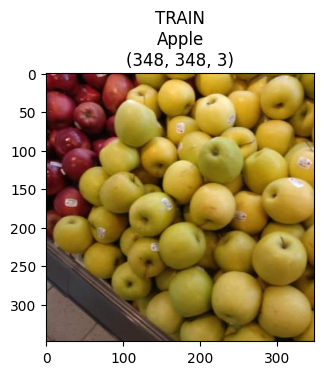

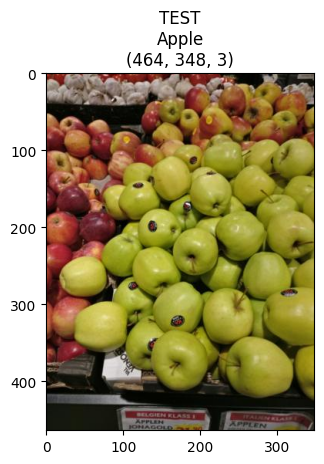

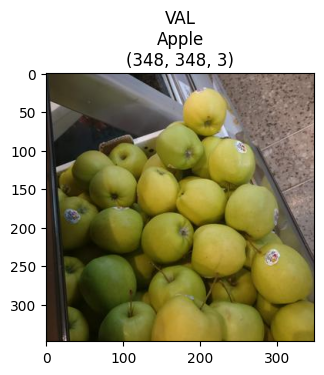

In [ ]:
datasets = df['dataset'].unique()

for dataset in datasets:
    row = df[df['dataset'] == dataset].iloc[0]
    coarse_cat = row['coarse_cat']
    image_data = row["image_data"]
    image = load_image_data(image_data)
    I = np.array(image)

    # Configuramos el tamaño de la figura basado en el tamaño de la imagen y DPI
    dpi = 100
    height, width = I.shape[:2]
    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)

    plt.imshow(I.astype(int))

    plt.title(f"{dataset.upper()}\n{coarse_cat}\n{I.shape}")

    plt.show()

## Aumento y normalización de imágenes para train y solo normalización para validación

In [ ]:
size = 224

# Tansformación de imágenes
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Seteos
batch_size = 32
learning_rate = 0.001
num_epochs = 40
num_classes = len(df['coarse_cat'].unique())

# Mapeo de clases a índices numéricos
class_to_idx = {cls: idx for idx, cls in enumerate(df['coarse_cat'].unique())}    # Creamos diccionario
labels = df['coarse_cat'].map(class_to_idx).values    # Vector de índices numéricos que representan la columna 'coarse_cat'

In [ ]:
print(class_to_idx)
print(labels)

{'Apple': 0, 'Pear': 1, 'Satsumas': 2, 'Melon': 3, 'Orange': 4}
[0 0 0 ... 4 4 4]


In [ ]:
#import torchvision
#print(torchvision.__version__)

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# Aplicamos transformaciones basadas en el conjunto de datos
data_tensors = {}
label_tensors = {}

# Transformamos imágenes y etiquetas para cada conjunto
for split in ['train', 'val']:
    transform = data_transforms[split]
    data_tensors[split] = torch.stack([
        transform(Image.open(io.BytesIO(image_data))) for image_data in df['image_data']
    ])
    label_tensors[split] = torch.tensor(labels)

# Creamos el conjunto de datos y lo dividimos en entrenamiento y validación
dataset_train = TensorDataset(data_tensors['train'], label_tensors['train'])
dataset_val = TensorDataset(data_tensors['val'], label_tensors['val'])

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Configuramos el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo ResNet preentrenado y ajustar la última capa para clasificar frutas/verduras
#model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Definimos la función de pérdida, el optimizador y el scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Entrenamos el modelo con ajuste dinámico del learning rate
best_val_loss = float('inf')
best_val_loss_epoch = None
best_val_loss_accurracy  = None
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculamos la pérdida de entrenamiento promedio
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Calculamos precisión de validación
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)   # Promedio de la pérdida
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

    # Ajustar el learning rate si el val_loss no mejora
    scheduler.step(val_loss)

    # Guardar el mejor modelo basado en la validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict().copy()
        best_val_loss_epoch = epoch+1
        best_val_loss_accurracy = accuracy
        print("Guardando el modelo con menor validation loss")

# Cargar el mejor modelo entrenado
model.load_state_dict(best_model_wts)
print("\nEntrenamiento completado.")
print(f"best_val_loss: {best_val_loss:.4f} (epoch: {best_val_loss_epoch}, Validation Accuracy: {best_val_loss_accurracy:.2f}%)")

Epoch [1/40], Training Loss: 0.6524
Validation Loss: 0.3709, Validation Accuracy: 86.95%
Guardando el modelo con menor validation loss
Epoch [2/40], Training Loss: 0.4318
Validation Loss: 0.8152, Validation Accuracy: 76.78%
Epoch [3/40], Training Loss: 0.3523
Validation Loss: 0.4949, Validation Accuracy: 79.84%
Epoch [4/40], Training Loss: 0.2996
Validation Loss: 0.2581, Validation Accuracy: 90.75%
Guardando el modelo con menor validation loss
Epoch [5/40], Training Loss: 0.3208
Validation Loss: 0.1966, Validation Accuracy: 92.31%
Guardando el modelo con menor validation loss
Epoch [6/40], Training Loss: 0.2329
Validation Loss: 0.1821, Validation Accuracy: 92.41%
Guardando el modelo con menor validation loss
Epoch [7/40], Training Loss: 0.1532
Validation Loss: 0.5810, Validation Accuracy: 82.42%
Epoch [8/40], Training Loss: 0.2469
Validation Loss: 0.1377, Validation Accuracy: 94.84%
Guardando el modelo con menor validation loss
Epoch [9/40], Training Loss: 0.2073
Validation Loss: 0.119

# Enfoques

## Enfoque 1

In [ ]:
# Definimos los precios de cada clase
class_prices = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

# Convertimos class_to_idx en idx_to_class para usar en el cálculo de costos
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Variables para conteo
total_cost = 0
total_correct = 0
total_errors = 0
errors_pred_less_than_real = 0
errors_pred_greater_than_real = 0
total_samples = len(val_loader.dataset)
error_details = []
image_id = 0  # Identificador único de imagen para todo el dataset

# Evaluación del modelo en el conjunto de validación
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Elegir la clase con mayor probabilidad

        for i in range(len(labels)):
            true_class = idx_to_class[labels[i].item()]
            pred_class = idx_to_class[predicted[i].item()]

            # Obtenemos precios reales y predichos
            Yreal = class_prices[true_class]
            Ypred = class_prices[pred_class]

            if pred_class == true_class:    # Contamos aciertos
                total_correct += 1
            else:                           # Calculamos el costo solo para predicciones incorrectas
                if Ypred > Yreal:
                    cost = 5 * (Ypred - Yreal)
                    errors_pred_greater_than_real += 1
                else:
                    cost = Yreal - Ypred
                    errors_pred_less_than_real += 1

                total_cost += cost  # Agregar el costo de error al total

                # Agregamos detalles de los errores para análisis
                error_details.append({
                    "Imagen ID": image_id,
                    "Clase Real": true_class,
                    "Clase Predicha": pred_class,
                    "Precio Real ($)": Yreal,
                    "Precio Predicho ($)": Ypred,
                    "Costo ($)": cost
                })

                total_errors += 1  # Contar error

            image_id += 1  # Incrementamos ID de imagen

# Calculamos el costo promedio, precisión y porcentajes de errores
average_cost = total_cost / total_samples if total_samples > 0 else 0
accuracy = (total_correct / total_samples) * 100 if total_samples > 0 else 0
error_pred_less_than_real_pct = (errors_pred_less_than_real / total_errors) * 100 if total_errors > 0 else 0
error_pred_greater_than_real_pct = (errors_pred_greater_than_real / total_errors) * 100 if total_errors > 0 else 0

# Ajustes para que se muestren todas las columnas en una sola línea
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

# Mostramos el costo total, el detalle de los errores y los porcentajes de errores
error_df = pd.DataFrame(error_details)
print("------------------------------------------------")
print("Detalles de costos para errores de clasificación")
print("------------------------------------------------")
print(error_df)
print(f"\nAccuracy en el conjunto de validación: {accuracy:.2f}%")
print(f"Cantidad de errores: {total_errors}/{total_samples}")
print(f"          -> Porcentaje de valor de etiqueta predicha menor que la real: {error_pred_less_than_real_pct:.2f}%")
print(f"          -> Porcentaje de valor de etiqueta predicha mayor que la real: {error_pred_greater_than_real_pct:.2f}%")
print(f"Costo promedio por predicción: ${average_cost:.2f}")
print(f"Costo total en el conjunto de validación: ${int(total_cost)}")

------------------------------------------------
Detalles de costos para errores de clasificación
------------------------------------------------
    Imagen ID Clase Real Clase Predicha  Precio Real ($)  Precio Predicho ($)  Costo ($)
0         389       Pear          Melon               89                  109        100
1         398   Satsumas         Orange               44                   35          9
2         424   Satsumas         Orange               44                   35          9
3         450   Satsumas           Pear               44                   89        225
4         462   Satsumas         Orange               44                   35          9
5         487      Melon          Apple              109                   74         35
6         506      Melon          Apple              109                   74         35
7         623     Orange       Satsumas               35                   44         45
8        1073   Satsumas         Orange             

## Enfoque 2

In [ ]:
# Definimos los precios de cada clase
class_prices = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

# Convertimos class_to_idx en idx_to_class para usar en el cálculo de costos
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Calculamos los costos esperados en el conjunto de validación
model.eval()
total_cost = 0
total_correct = 0
total_samples = len(val_loader.dataset)
total_errors = 0
errors_pred_less_than_real = 0
errors_pred_greater_than_real = 0
error_details = []  # Almacenará los detalles de cada error

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Convertimos logits a probabilidades

        for i in range(len(labels)):
            true_class = idx_to_class[labels[i].item()]
            Yreal = class_prices[true_class]  # Precio real del artículo

            # Calculamos el costo esperado para cada clase
            expected_costs = []
            for pred_class_idx, pred_class_name in idx_to_class.items():
                Ypred = class_prices[pred_class_name]

                # Calculamos el costo ponderado de elegir `pred_class`
                cost_sum = 0
                for other_class_idx, other_class_name in idx_to_class.items():
                    if pred_class_name == other_class_name:
                        continue
                    other_price = class_prices[other_class_name]
                    if Ypred > other_price:
                        cost = 5 * (Ypred - other_price)
                    else:
                        cost = (other_price - Ypred)
                    cost_sum += probabilities[i, other_class_idx].item() * cost

                expected_costs.append((cost_sum, pred_class_idx))

            # Elegimos la clase con el costo esperado mínimo
            min_cost_class_idx = min(expected_costs, key=lambda x: x[0])[1]
            min_cost_class_name = idx_to_class[min_cost_class_idx]

            # Calculamos el costo real comparando con la etiqueta verdadera
            Ypred_optimal = class_prices[min_cost_class_name]
            if Ypred_optimal > Yreal:
                cost = 5 * (Ypred_optimal - Yreal)
                errors_pred_greater_than_real += 1  # Predicción mayor que real
            elif Ypred_optimal < Yreal:
                cost = Yreal - Ypred_optimal
                errors_pred_less_than_real += 1  # Predicción menor que real
            else:
                cost = 0  # Ypred_optimal == Yreal

            total_cost += cost

            # Guardamos detalles de error si hay un error de predicción
            if Ypred_optimal != Yreal:
                total_errors += 1
                error_details.append({
                    'True_Class': true_class,
                    'Pred_Class': min_cost_class_name,
                    'Yreal': Yreal,
                    'Ypred': Ypred_optimal,
                    'Cost': cost
                })

            # Contamos aciertos
            if min_cost_class_name == true_class:
                total_correct += 1

# Calculamos el costo promedio, precisión y porcentajes de errores
average_cost = total_cost / total_samples
accuracy = (total_correct / total_samples) * 100
error_pred_less_than_real_pct = (errors_pred_less_than_real / total_errors) * 100 if total_errors > 0 else 0
error_pred_greater_than_real_pct = (errors_pred_greater_than_real / total_errors) * 100 if total_errors > 0 else 0

# Mostramos el costo total, los detalles de los errores y los porcentajes de errores
error_df = pd.DataFrame(error_details)
print("------------------------------------------------")
print("Detalles de costos para errores de clasificación")
print("------------------------------------------------")
print(error_df)
print(f"\nAccuracy en el conjunto de validación: {accuracy:.2f}%")
print(f"Cantidad de errores: {total_errors}/{total_samples}")
print(f"          -> Porcentaje de valor de etiqueta predicha menor que la real: {error_pred_less_than_real_pct:.2f}%")
print(f"          -> Porcentaje de valor de etiqueta predicha mayor que la real: {error_pred_greater_than_real_pct:.2f}%")
print(f"Costo promedio por predicción: ${average_cost:.2f}")
print(f"Costo total en el conjunto de validación: ${int(total_cost)}")

------------------------------------------------
Detalles de costos para errores de clasificación
------------------------------------------------
   True_Class Pred_Class  Yreal  Ypred  Cost
0        Pear      Apple     89     74    15
1        Pear      Apple     89     74    15
2        Pear      Apple     89     74    15
3        Pear      Apple     89     74    15
4        Pear      Melon     89    109   100
5    Satsumas     Orange     44     35     9
6    Satsumas     Orange     44     35     9
7    Satsumas     Orange     44     35     9
8    Satsumas     Orange     44     35     9
9    Satsumas     Orange     44     35     9
10   Satsumas     Orange     44     35     9
11      Melon      Apple    109     74    35
12      Melon      Apple    109     74    35
13      Melon      Apple    109     74    35
14   Satsumas     Orange     44     35     9
15   Satsumas     Orange     44     35     9
16   Satsumas     Orange     44     35     9
17   Satsumas     Orange     44     35     

### Verificación de los cálculos de optimización del modelo

Clase real: Apple (Precio: $74)



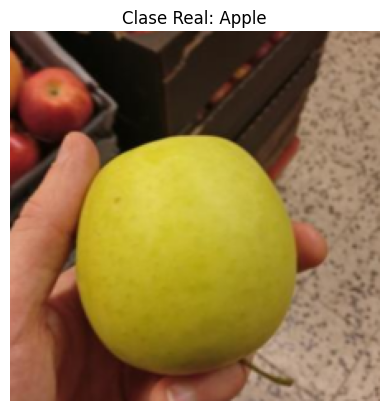

--------------------------
Probabilidad de cada clase
--------------------------
Clase: Apple - Probabilidad: 0.83
Clase: Melon - Probabilidad: 0.17

------------------------------------------
Cálculo del costo esperado para cada clase
------------------------------------------

Para clase predicha 'Apple' (Precio: $74):
- Probabilidad de 'Melon' = 0.17, Costo: (109 - 74) = 35, Costo Ponderado: 0.17 * 35 = 6.11
Costo esperado total para 'Apple': 6.11

Para clase predicha 'Pear' (Precio: $89):
- Probabilidad de 'Apple' = 0.83, Costo: 5 * (89 - 74) = 75, Costo Ponderado: 0.83 * 75 = 61.88
- Probabilidad de 'Melon' = 0.17, Costo: (109 - 89) = 20, Costo Ponderado: 0.17 * 20 = 3.49
Costo esperado total para 'Pear': 65.37

Para clase predicha 'Satsumas' (Precio: $44):
- Probabilidad de 'Apple' = 0.83, Costo: (74 - 44) = 30, Costo Ponderado: 0.83 * 30 = 24.75
- Probabilidad de 'Melon' = 0.17, Costo: (109 - 44) = 65, Costo Ponderado: 0.17 * 65 = 11.35
Costo esperado total para 'Satsumas': 36.1

In [ ]:
# Definimos los precios de cada clase
class_prices = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

# Convertimos class_to_idx en idx_to_class para usar en el cálculo de costos
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Buscamos un ejemplo con probabilidades repartidas
model.eval()
selected_example = None

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Convertimos logits a probabilidades

        # Iteramos por cada imagen del batch
        for i in range(len(labels)):
            prob_dist = probabilities[i]
            max_prob = prob_dist.max().item()

            # Si la probabilidad máxima es menor a 90%, elegimos este ejemplo
            if max_prob < 0.9:
                selected_example = (images[i], labels[i], prob_dist)
                break
        if selected_example:
            break

# Nos aseguramos que se encontró un ejemplo adecuado
if not selected_example:
    print("No se encontró un ejemplo con probabilidades repartidas en el conjunto de validación.")
else:
    image, true_label, prob_dist = selected_example
    true_class = idx_to_class[true_label.item()]
    Yreal = class_prices[true_class]  # Precio real del artículo

    print(f"Clase real: {true_class} (Precio: ${Yreal})\n")

    # Mostramos la imagen
    image_to_show = image.cpu().permute(1, 2, 0)  # Desnormalizar para mostrar
    image_to_show = image_to_show * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Desnormalizar
    image_to_show = image_to_show.clamp(0, 1)
    plt.imshow(image_to_show)
    plt.axis('off')
    plt.title(f"Clase Real: {true_class}")
    plt.show()

    # Mostramos las probabilidades de cada clase para el ejemplo
    print("--------------------------")
    print("Probabilidad de cada clase")
    print("--------------------------")
    for class_idx, class_name in idx_to_class.items():
      probability = prob_dist[class_idx].item()
      if round(probability, 2) > 0:
        print(f"Clase: {class_name} - Probabilidad: {probability:.2f}")

    # Calculamos el costo esperado para cada clase
    print('\n------------------------------------------')
    print("Cálculo del costo esperado para cada clase")
    print('------------------------------------------')
    expected_costs = []
    for pred_class_idx, pred_class_name in idx_to_class.items():
        Ypred = class_prices[pred_class_name]

        # Calculamos el costo ponderado de elegir `pred_class`
        cost_sum = 0
        print(f"\nPara clase predicha '{pred_class_name}' (Precio: ${Ypred}):")
        for other_class_idx, other_class_name in idx_to_class.items():
            if pred_class_name == other_class_name:
                continue
            other_price = class_prices[other_class_name]
            prob_other = prob_dist[other_class_idx].item()

            if round(prob_other, 2) > 0:
              # Determinamos la fórmula a aplicar y calculamos el costo
              if Ypred > other_price:
                cost = 5 * (Ypred - other_price)
                formula = f"5 * ({Ypred} - {other_price}) = {cost}"
              else:
                cost = other_price - Ypred
                formula = f"({other_price} - {Ypred}) = {cost}"

              # Sumamos el costo ponderado por la probabilidad de la clase alternativa
              weighted_cost = prob_other * cost
              cost_sum += weighted_cost

              print(f"- Probabilidad de '{other_class_name}' = {prob_other:.2f}, Costo: {formula}, "
                  f"Costo Ponderado: {prob_other:.2f} * {cost} = {weighted_cost:.2f}")

        expected_costs.append((cost_sum, pred_class_name))
        print(f"Costo esperado total para '{pred_class_name}': {cost_sum:.2f}")

    # Elegimos la clase con el costo esperado mínimo
    min_cost_class_name = min(expected_costs, key=lambda x: x[0])[1]
    print(f"\nClase seleccionada para minimizar el costo esperado: {min_cost_class_name}\n")

    # Mostramos resultados
    print(f"Clase Real: {true_class}")
    print(f"Clase Seleccionada: {min_cost_class_name}")

In [ ]:
# Lista de clases
class_names = list(class_to_idx.keys())

# Predicción en el conjunto de validación para la matriz de confusión
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)  # Obtener la clase predicha

        # Guardamos las etiquetas reales y las predicciones
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convertimos a arrays de NumPy para optimizar rendimiento en cálculos posteriores
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Creamos el gráfico de calor interactivo con Plotly, incluyendo los valores en cada celda
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    colorbar=dict(title="Número de instancias"),
    text=conf_matrix,
    texttemplate="%{text}",
    textfont={"size": 12},
    hovertemplate="Clase Verdadera: %{y}<br>Clase Predicha: %{x}<br>Valor: %{z}<extra></extra>"
))

# Configuración de etiquetas, título y tamaño
fig.update_layout(
    title="Matriz de Confusión para el Conjunto de Validación",
    xaxis=dict(title="Clase Predicha"),
    yaxis=dict(title="Clase Verdadera", autorange="reversed"),
    width=700,
    height=500
)

# Mostramos el gráfico
fig.show()

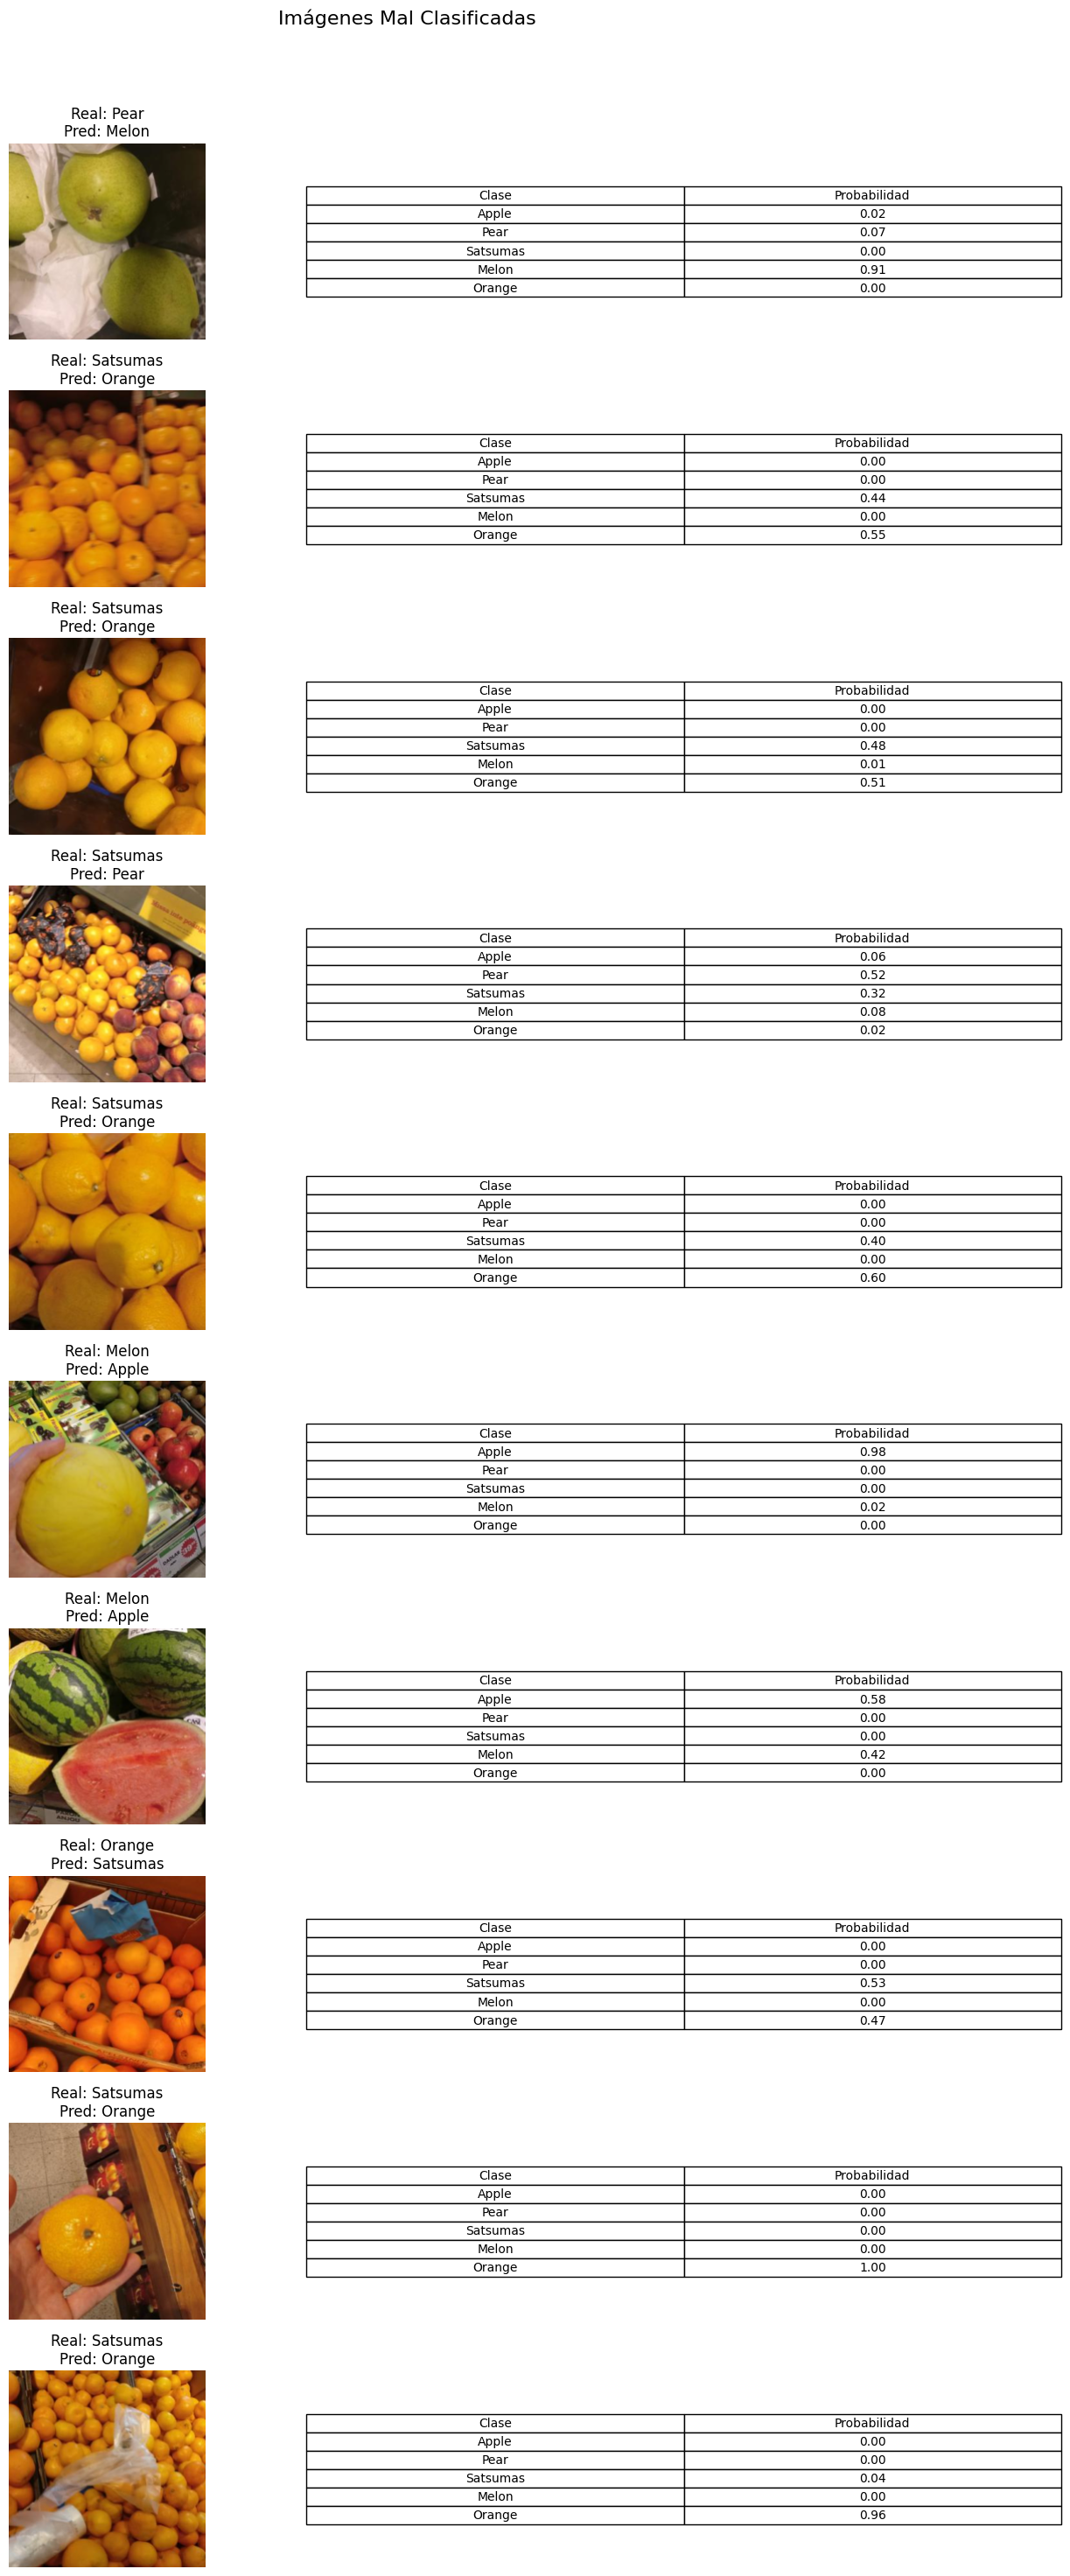

In [ ]:
# Configuración: Número de errores a mostrar
num_errors_to_show = 10

# Lista de clases
class_names = list(class_to_idx.keys())

# Recolección de imágenes mal clasificadas, etiquetas y probabilidades
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []
incorrect_probabilities = []

# Desnormalización (valores predefinidos para eficiencia)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Convertimos logits a probabilidades
        _, predicted = torch.max(outputs, 1)

        # Identificamos las imágenes mal clasificadas
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_images.append(images[i].cpu())
                incorrect_labels.append(labels[i].cpu().item())
                incorrect_predictions.append(predicted[i].cpu().item())
                incorrect_probabilities.append(probabilities[i].cpu().numpy())  # Guardamos probabilidades

# Verificamos si hay imágenes mal clasificadas
if incorrect_images:
    # Mostramos las imágenes mal clasificadas junto con las probabilidades en formato de tabla
    fig, axes = plt.subplots(min(num_errors_to_show, len(incorrect_images)), 2, figsize=(15, num_errors_to_show * 3))
    fig.suptitle("Imágenes Mal Clasificadas", fontsize=16)

    for i in range(min(num_errors_to_show, len(incorrect_images))):
        img = incorrect_images[i]
        true_label = class_names[incorrect_labels[i]]
        pred_label = class_names[incorrect_predictions[i]]
        probs = incorrect_probabilities[i]

        # Convertimos el tensor de imagen a un formato de imagen para matplotlib
        img = img.permute(1, 2, 0).numpy()  # Cambiamos de [C, H, W] a [H, W, C] y convertimos a numpy
        img = img * std + mean  # Desnormalizamos
        img = img.clip(0, 1)  # Limitamos los valores al rango [0, 1]

        # Mostramos imagen en la primera columna
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Real: {true_label}\nPred: {pred_label}")
        axes[i, 0].axis("off")

        # Creamos una tabla de probabilidades en la segunda columna
        # prob_data = pd.DataFrame({"Clase": class_names, "Probabilidad": probs.round(2)})    # Forma 1
        prob_data = pd.DataFrame({"Clase": class_names, "Probabilidad": probs})              # Forma 2
        prob_data["Probabilidad"] =  prob_data["Probabilidad"].apply(lambda x: f"{x:.2f}")   # Forma 2
        #prob_data_filtered = prob_data[prob_data["Probabilidad"].astype(float) > 0]           # Solo se muestran Probabilidades > 0
        axes[i, 1].axis("off")  # Desactivamos eje
        table = axes[i, 1].table(cellText=prob_data.values, colLabels=prob_data.columns, cellLoc="center", loc="center")
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.1, 1.1)  # Ajustamos la escala para mejor legibilidad

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustamos layout para el título
    plt.show()
else:
    print("No se encontraron imágenes mal clasificadas en el conjunto de validación.")

## Enfoque 3

In [ ]:
# Definimos los precios de cada clase
class_prices = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

# Convertimos class_to_idx en idx_to_class para usar en el cálculo de costos
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_to_price_sorted = sorted(class_prices.items(), key=lambda x: x[1])  # Ordenamos clases por precio
prob_threshold = 0.98  # Umbral de probabilidad para ajustar la predicción

# Variables para conteo
total_cost = 0
total_correct = 0
total_errors = 0
errors_pred_less_than_real = 0
errors_pred_greater_than_real = 0
total_samples = len(val_loader.dataset)
error_details = []

# Evaluamos el modelo en el conjunto de validación
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Convertimos logits a probabilidades

        for i in range(len(labels)):
            true_class = idx_to_class[labels[i].item()]
            Yreal = class_prices[true_class]  # Precio real del artículo

            # Obtenemos la predicción con mayor probabilidad
            top_prob, top_class_idx = probabilities[i].max(0)
            top_class_name = idx_to_class[top_class_idx.item()]
            Ypred = class_prices[top_class_name]

            # Ajustamos predicción si la probabilidad es menor que el umbral
            if top_prob.item() < prob_threshold:
                # Filtramos etiquetas con precios inferiores al precio predicho actual
                lower_price_classes = [cls for cls, price in class_to_price_sorted if price < Ypred]

                if lower_price_classes:  # Si hay opciones de precio inferior
                    # Elegimos la clase de precio inferior con la mayor probabilidad
                    lower_probs = {cls: probabilities[i, class_to_idx[cls]].item() for cls in lower_price_classes}
                    selected_class = max(lower_probs, key=lower_probs.get)
                    Ypred = class_prices[selected_class]  # Actualizamos el precio predicho
                    top_class_name = selected_class       # Actualizamos la clase predicha

            # Calculamos el costo solo para predicciones incorrectas
            if Ypred != Yreal:
                if Ypred > Yreal:
                    cost = 5 * (Ypred - Yreal)
                    errors_pred_greater_than_real += 1
                else:
                    cost = Yreal - Ypred
                    errors_pred_less_than_real += 1

                total_cost += cost  # Agregamos el costo de error al total

                # Agregamos detalles de los errores para análisis
                error_details.append({
                    "Imagen ID": i,
                    "Clase Real": true_class,
                    "Clase Predicha": top_class_name,
                    "Precio Real ($)": Yreal,
                    "Precio Predicho ($)": Ypred,
                    "Costo ($)": cost
                })

                total_errors += 1  # Contar error

            # Contamos aciertos
            if top_class_name == true_class:
                total_correct += 1

# Calculamos el costo promedio, precisión y porcentajes de errores
average_cost = total_cost / total_errors if total_errors > 0 else 0
accuracy = (total_correct / total_samples) * 100
error_pred_less_than_real_pct = (errors_pred_less_than_real / total_errors) * 100 if total_errors > 0 else 0
error_pred_greater_than_real_pct = (errors_pred_greater_than_real / total_errors) * 100 if total_errors > 0 else 0

# Mostramos el costo total, los detalles de los errores y los porcentajes de errores
error_df = pd.DataFrame(error_details)
print("------------------------------------------------")
print("Detalles de costos para errores de clasificación")
print("------------------------------------------------")
print(error_df.head(10))  # Mostramos solo los primeros 10 errores
print(f"\nAccuracy en el conjunto de validación: {accuracy:.2f}%")

print(f"Cantidad de errores: {total_errors}/{total_samples}")
print(f"          -> Porcentaje de valor de etiqueta predicha menor que la real: {error_pred_less_than_real_pct:.2f}%")
print(f"          -> Porcentaje de valor de etiqueta predicha mayor que la real: {error_pred_greater_than_real_pct:.2f}%")
print(f"Costo promedio por error de predicción: ${average_cost:.2f}")
print(f"Costo total en el conjunto de validación: ${int(total_cost)}")

------------------------------------------------
Detalles de costos para errores de clasificación
------------------------------------------------
   Imagen ID Clase Real Clase Predicha  Precio Real ($)  Precio Predicho ($)  Costo ($)
0          6      Apple         Orange               74                   35         39
1         20      Apple         Orange               74                   35         39
2         24      Apple       Satsumas               74                   44         30
3         18      Apple         Orange               74                   35         39
4          4      Apple         Orange               74                   35         39
5          4      Apple       Satsumas               74                   44         30
6         13      Apple         Orange               74                   35         39
7         15      Apple       Satsumas               74                   44         30
8         17      Apple         Orange               74      